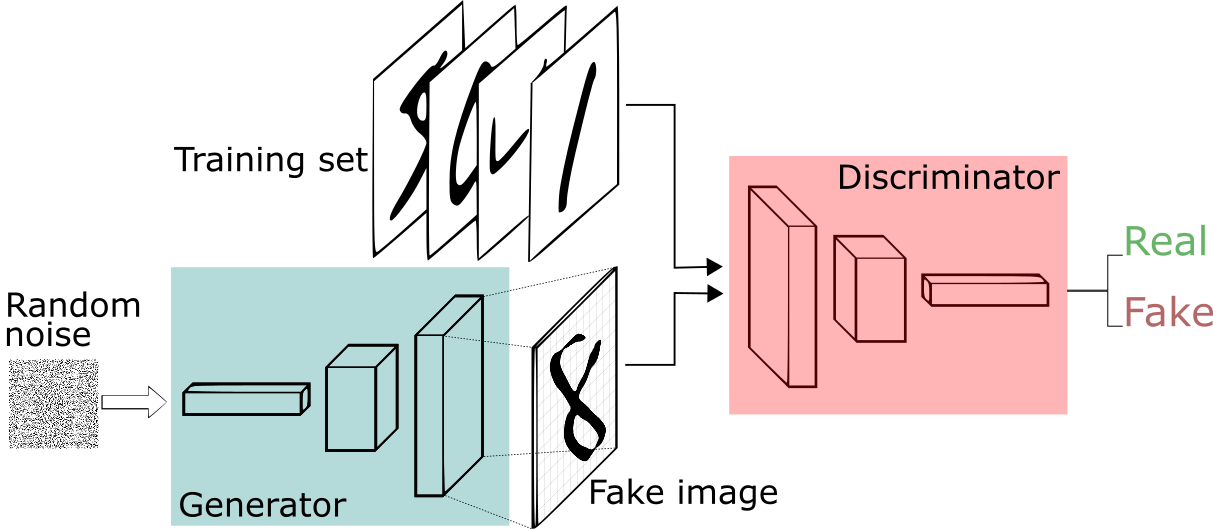

# **SETUP GOOGLE RUNTIME T4 GPU**

The **role of the generator** is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data.

The **Discriminator** is a neural network that identifies real data from the fake data created by the Generator. The discriminator's training data comes from different sources: The real data instances, such as real pictures of birds, humans, currency notes, etc., are used by the Discriminator as positive samples during training.

**Torch** is an open source **ML library** used for creating deep neural networks and is written in the **Lua scripting** language.



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

CUDA (or Compute Unified Device Architecture) is a proprietary and closed source parallel computing platform and application programming interface (API) that allows software to use certain types of graphics processing units (GPUs) for general purpose processing, an approach called general-purpose computing on GPUs (GPGPU). CUDA is a software layer that gives direct access to the GPU's virtual instruction set and parallel computational elements, for the execution of compute kernels.

**beta_1** is used for ADAM OPTIMIZER.

**The optimizer is used to decrease the rates of error during training the neural networks.**

**Adam optimizer** involves a combination of two gradient descent methodologies:


This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the ‘exponentially weighted average’ of the gradients. Using **averages** makes the algorithm **converge towards the minima in a faster pace**

ADAM OPTIMIZER :



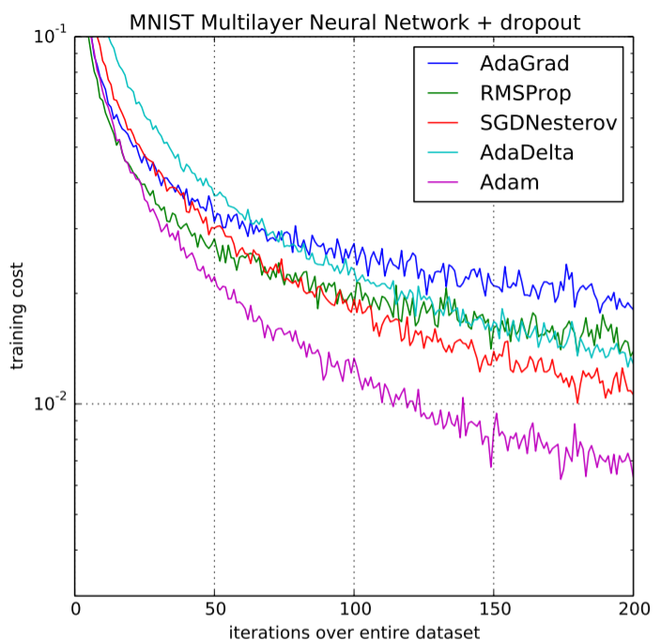

In [ ]:
device = 'cuda'  # tranfer image(TENSORS) to GPU , image = image.to(device)
batch_size = 128 # used in train loader and training loop
noise_dim = 64   # used in creating generator models

#optimizer parameters

lr = 0.0002      # learning rate
beta_1 = 0.5     # passed in ADAM OPTIMIZER
beta_2 = 0.99    # passed in ADAM OPTIMIZER

#Training variables

epochs = 10       #(How many times we want to run our training loop?)

# **LOAD MNIST HANDWRITTEN DATASETS**

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([T.RandomRotation((-20,+20)),
                        T.ToTensor() # (h[height],w[width],c[channel]) -> (c,h,w)
                        ])

In [ ]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform= train_augs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 959110.57it/s] 


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135554.03it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:05<00:00, 318457.32it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4353411.51it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



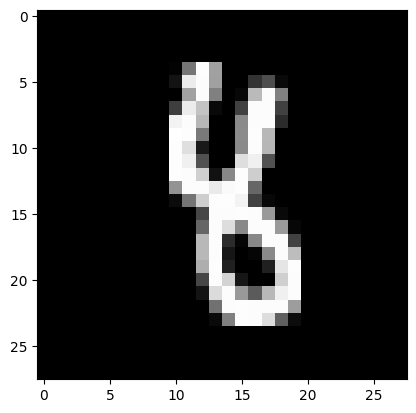

In [ ]:
image, label = trainset[7000]
plt.imshow(image.squeeze() , cmap = 'gray')

In [ ]:
print("Total images present in trainset are:", len(trainset))

Total images present in trainset are: 60000


# **LOAD DATASET into BATCHES**

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset,batch_size = batch_size, shuffle = True)

In [ ]:
print("Total no. of batches in trainLoader:", len(trainloader))

Total no. of batches in trainLoader: 469


In [ ]:
dataiter = iter(trainloader)
images, _ = dataiter.__next__()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
def show_tensor_images (tensor_img, num_images = 16, size=(1, 28, 28)):
  unflat_img  = tensor_img.detach().cpu()
  img_grid =  make_grid(unflat_img[:num_images], nrow=4)
  plt.imshow(img_grid.permute(1, 2, 0).squeeze())
  plt.show()

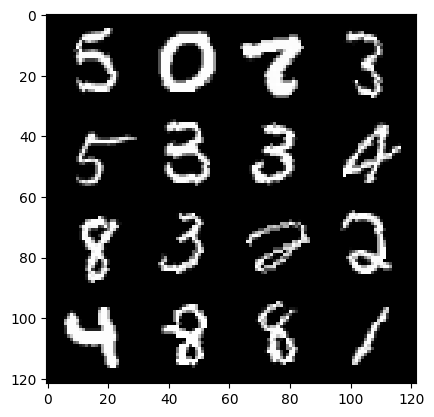

In [ ]:
show_tensor_images(images, num_images = 16)

# **CREATE DISCRIMINATOR IMAGES**


In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def get_disc_block(in_channels,out_channels, kernel_size,stride):
    return nn.Sequential(
       nn.Conv2d(in_channels,out_channels,kernel_size,stride),
       nn.BatchNorm2d(out_channels),
       nn.LeakyReLU(0.2)
    )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block_1 = get_disc_block(1,16,(3,3),2)
    self.block_2 = get_disc_block(16,32,(5,5),2)
    self.block_3 = get_disc_block(32,64,(5,5),2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64,out_features = 1)
  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    return x5

The D.to(device) is used to move the discriminator network to the specified device.

The device argument can be either cpu or cuda, depending on whether you want to use the CPU or the GPU.

In [ ]:
D =Discriminator()
D.to(device)
summary(D,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# **GENERATOR NETWORK**

In [ ]:
def get_gen_block(in_channels,out_channels,kernel_size,stride,final_block=False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )

In [ ]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)
    self.block_4 = get_gen_block(64,1,(4,4),2,final_block = True)
  def forward(self,r_noise_vec):
    x= r_noise_vec.view(-1,self.noise_dim,1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)
    return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)
summary(G,input_size = (1,noise_dim))

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn. BatchNorm2d):
      nn.init.normal_(m.weight, 0.0, 0.02)
      nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

#**CREATE LOSS FUNCTION AND LOAD OPTIMIZER**

In [ ]:
def real_loss (disc_pred):
  criterion= nn. BCEWithLogitsLoss()
  ground_truth = torch.ones_like (disc_pred)
  loss = criterion (disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion= nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(),lr = lr,betas = (beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(),lr = lr,betas = (beta_1,beta_2))

# **TRAINING GAN**

100%|██████████| 469/469 [00:20<00:00, 23.39it/s]


Epoch: 1 | D_loss : 0.6848855919675279 | G_loss : 0.6965302920290656


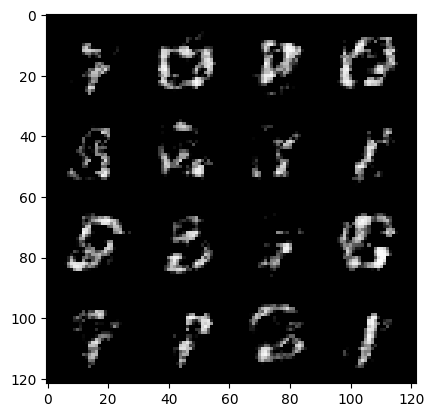

100%|██████████| 469/469 [00:19<00:00, 24.53it/s]


Epoch: 2 | D_loss : 0.6777933515719513 | G_loss : 0.7113576274690852


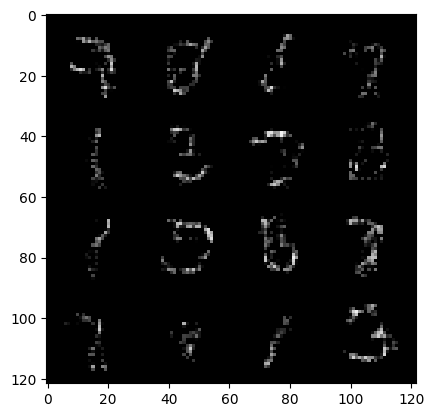

100%|██████████| 469/469 [00:18<00:00, 25.18it/s]


Epoch: 3 | D_loss : 0.6139451078514555 | G_loss : 0.7856070451390769


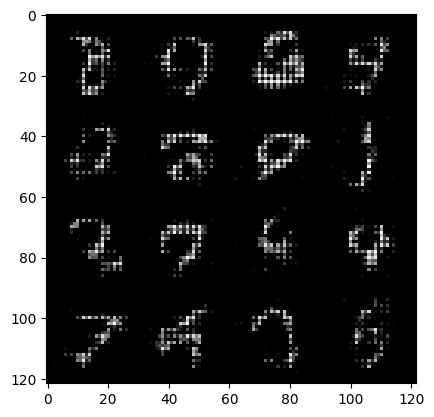

100%|██████████| 469/469 [00:19<00:00, 23.63it/s]


Epoch: 4 | D_loss : 0.549105096727546 | G_loss : 0.8770205065893975


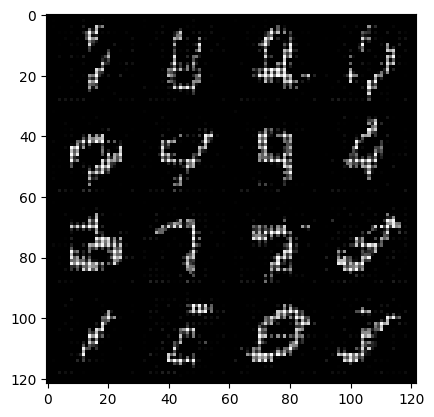

100%|██████████| 469/469 [00:19<00:00, 24.57it/s]


Epoch: 5 | D_loss : 0.5233268593547187 | G_loss : 0.9329167811601147


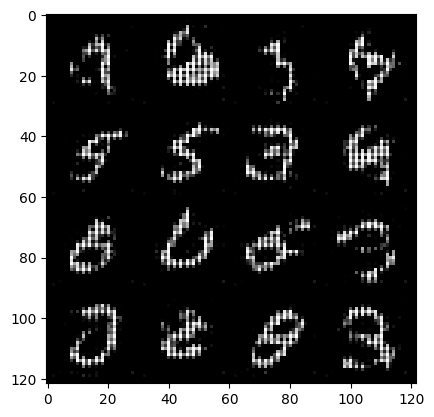

100%|██████████| 469/469 [00:19<00:00, 24.21it/s]


Epoch: 6 | D_loss : 0.5095031183284483 | G_loss : 0.9852305918868417


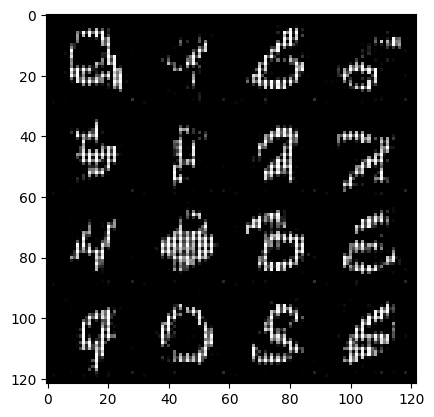

100%|██████████| 469/469 [00:20<00:00, 23.39it/s]


Epoch: 7 | D_loss : 0.49108225812535805 | G_loss : 1.0473793023176539


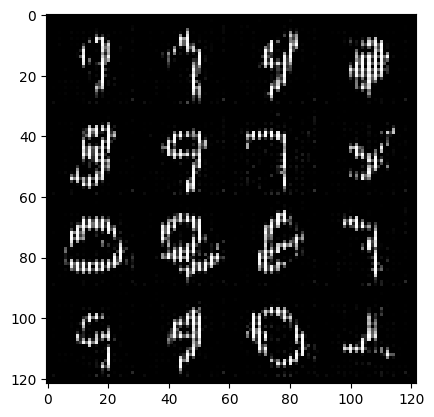

100%|██████████| 469/469 [00:18<00:00, 24.71it/s]


Epoch: 8 | D_loss : 0.4863447632108416 | G_loss : 1.077775261041198


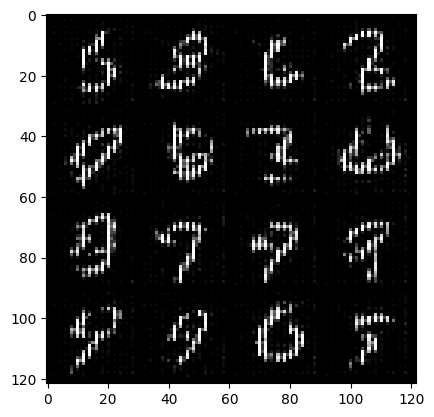

100%|██████████| 469/469 [00:19<00:00, 23.93it/s]


Epoch: 9 | D_loss : 0.47436875556069397 | G_loss : 1.1478833821790813


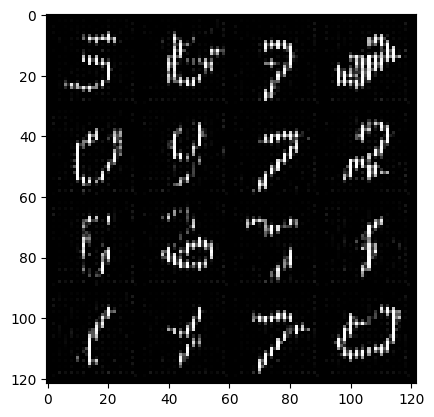

100%|██████████| 469/469 [00:19<00:00, 23.80it/s]


Epoch: 10 | D_loss : 0.45635605589159006 | G_loss : 1.2307301511896698


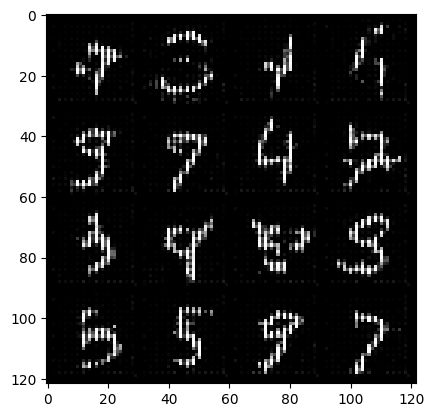

In [25]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size,noise_dim,device = device)
    D_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)

    D_real_loss = real_loss (D_pred)
    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()

#find loss ad update weights for 6

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_img =  G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss (D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D_loss : {} | G_loss : {}".format(i+1,avg_d_loss,avg_g_loss))

  show_tensor_images(fake_img)